# Monte carlo simulation and BC #
reference: https://github.com/romanmichaelpaolucci/Quant-Guild-Library/blob/main/2025%20Video%20Lectures/19.%20Monte%20Carlo%20Simulation%20and%20Black-Scholes%20for%20Pricing%20Options/montecarlo_blackshcoles.ipynb

# Summary #
1. Simulate random variables and compare sample means to expectations
2. Simulate stock price paths using 1.
3. Use monte carlo to price options and compare to black scholes

# Equations #
Exponential distribution pdf: $$ f(x) = \lambda e^{- \lambda x} $$

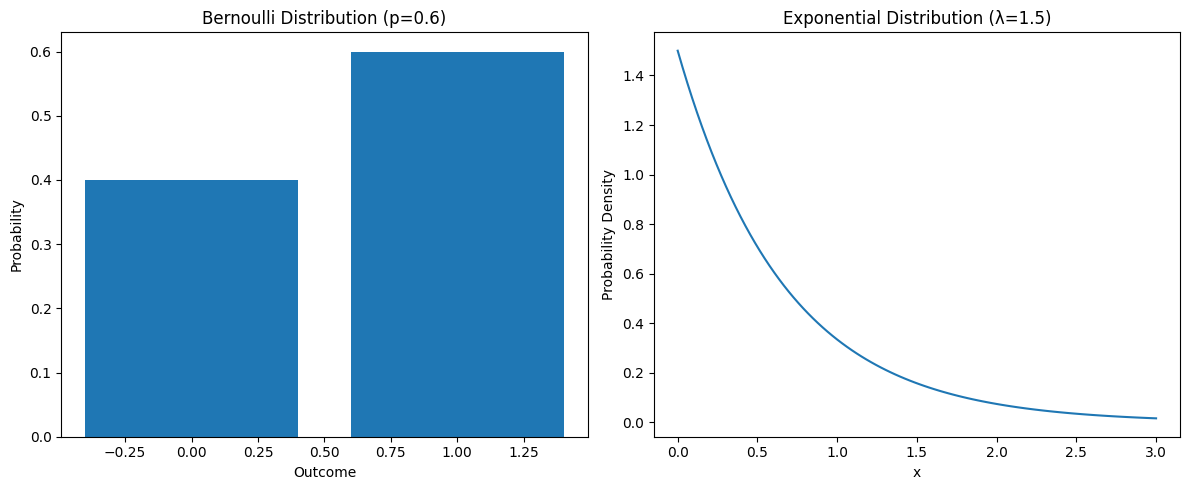


Analytical Expectations:
Bernoulli (p=0.6): E[X] = 0.6000
Exponential (λ=1.5): E[X] = 0.6667


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
np.random.seed(42)

p_bernoulli = 0.6
lambda_exp = 1.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x_bernoulli = np.array([0, 1])
pmf_bernoulli = np.array([1-p_bernoulli, p_bernoulli])
ax1.bar(x_bernoulli, pmf_bernoulli)
ax1.set_title(f'Bernoulli Distribution (p={p_bernoulli})')
ax1.set_xlabel('Outcome')
ax1.set_ylabel('Probability')

# Exponential distribution visualization
x_exp = np.linspace(0, 3, 100)
pdf_exp = lambda_exp * np.exp(-lambda_exp * x_exp)
ax2.plot(x_exp, pdf_exp)
ax2.set_title(f'Exponential Distribution (λ={lambda_exp})')
ax2.set_xlabel('x')
ax2.set_ylabel('Probability Density')

plt.tight_layout()
plt.show()

# Calculate analytical expectations
bernoulli_expectation = p_bernoulli  # E[X] = p for Bernoulli
exponential_expectation = 1/lambda_exp  # E[X] = 1/λ for Exponential

print("\nAnalytical Expectations:")
print(f"Bernoulli (p={p_bernoulli}): E[X] = {bernoulli_expectation:.4f}")
print(f"Exponential (λ={lambda_exp}): E[X] = {exponential_expectation:.4f}")


In [3]:
# Monte Carlo simulations for approximating expected value
n_samples = 100000

bernoulli_sum = 0
for i in range(n_samples):
    # Generate random number between 0 and 1
    u = np.random.random()
    # If u < p, count as success (1), else failure (0)
    bernoulli_sum += 1 if u < p_bernoulli else 0
bernoulli_naive_mean = bernoulli_sum / n_samples

# Exponential naive Monte Carlo
exponential_sum = 0
for i in range(n_samples):
    # Generate random number between 0 and 1
    u = np.random.random()
    # Inverse transform sampling: F^(-1)(u) = -ln(1-u)/λ
    exponential_sum += -np.log(1-u)/lambda_exp
exponential_naive_mean = exponential_sum / n_samples

print("\nNaive Monte Carlo Results (n =", n_samples, "):")
print(f"Bernoulli naive MC mean: {bernoulli_naive_mean:.4f} (vs analytical {bernoulli_expectation:.4f})")
print(f"Exponential naive MC mean: {exponential_naive_mean:.4f} (vs analytical {exponential_expectation:.4f})")


Naive Monte Carlo Results (n = 100000 ):
Bernoulli naive MC mean: 0.5999 (vs analytical 0.6000)
Exponential naive MC mean: 0.6697 (vs analytical 0.6667)


For some geometric brownian motion of the stock price: 
$$dS_t = rS_tdt + \sigma S_tdW_t$$
where:
- $S_t$ is the stock price at time $t$
- $r$ is the risk-free rate
- $\sigma$ is the volatility
- $W_t$ is a standard Brownian motion

Under the assumption of no arbitrage opportunities (fair pricing)
1. Consider a portfolio Π consisting of:
    - Long one call option V(S,t)
    - Short Δ shares of stock

2. The value of this portfolio is:
    $$\Pi = V - \Delta S$$

3. The change in portfolio value over dt is:
    $$d\Pi = dV - \Delta dS$$

4. Using Itô's lemma, the change in option value is:
    $$dV = \frac{\partial V}{\partial t}dt + \frac{\partial V}{\partial S}dS + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}(dS)^2$$

5. Substituting $dS = rSdt + \sigma SdW$ and $(dS)^2 = \sigma^2S^2dt$:
    $$d\Pi = (\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2})dt + (\frac{\partial V}{\partial S} - \Delta)dS$$

6. Choose $\Delta = \frac{\partial V}{\partial S}$ to eliminate risk (delta-hedging)

7. No-arbitrage implies the portfolio must earn the risk-free rate:
    $$d\Pi = r\Pi dt$$

8. This yields the Black-Scholes PDE:
   $$\frac{\partial V}{\partial t} + rS\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} = rV$$

9. Solving this PDE with boundary condition $V(S,T) = \max(S-K,0)$ gives:

$$C(S_0, K, T) = S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$$

where:
$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$
$$d_2 = d_1 - \sigma\sqrt{T}$$
and $\Phi$ is the standard normal CDF.

For simulating using monte carlo:
Each sample draws from a terminal stock price (distribution created from the geometric brownian motion),
calculate option payoff and average then discount for all samples.

In [ ]:
from scipy.stats import norm
# option pricing example using black scholes
def black_scholes_call(S0, K, T, r, sigma):
    """Analytical Black-Scholes call option price"""
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Create interactive plot
from ipywidgets import interactive
import ipywidgets as widgets

def plot_bs_price(S0, K, T, r, sigma):
    # Calculate option price
    price = black_scholes_call(S0, K, T, r, sigma)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), facecolor='white')
    plt.style.use('default')
    
    # Left subplot - Option price curve
    S_range = np.linspace(max(0, S0-50), S0+50, 200)
    prices = [black_scholes_call(s, K, T, r, sigma) for s in S_range]
    
    ax1.plot(S_range, prices, color='#2E86C1', linewidth=2, label='Option Price Curve')
    ax1.scatter(S0, price, color='#E74C3C', s=100, zorder=5, label='Current Price')
    
    ax1.set_xlabel('Underlying Price ($)', fontsize=12)
    ax1.set_ylabel('Option Price ($)', fontsize=12)
    ax1.set_title('Black-Scholes Call Option Price', fontsize=14, pad=15)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Add text box with parameters
    param_text = f'Parameters:\nStrike (K): ${K:.2f}\nMaturity (T): {T:.1f}y\nRate (r): {r:.1%}\nVol (σ): {sigma:.1%}'
    ax1.text(0.02, 0.98, param_text, transform=ax1.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Right subplot - Terminal price distribution
    n_samples = 10000
    Z = np.random.standard_normal(n_samples)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    
    ax2.hist(ST, bins=50, density=True, alpha=0.7, color='#2E86C1')
    ax2.axvline(x=S0, color='#E74C3C', linestyle='--', label='Current Price')
    ax2.axvline(x=K, color='green', linestyle='--', label='Strike Price')
    
    ax2.set_xlabel('Terminal Stock Price ($)', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.set_title('Terminal Price Distribution', fontsize=14, pad=15)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Option price for S0=${S0:.2f}: ${price:.4f}")

# Create interactive sliders
interactive_plot = interactive(
    plot_bs_price,
    S0=widgets.FloatSlider(
        value=100,
        min=50,
        max=150,
        step=1,
        description='Stock Price ($):',
        continuous_update=False,
        style={'description_width': 'initial'}
    ),
    K=widgets.FloatSlider(
        value=100,
        min=50,
        max=150,
        step=1,
        description='Strike Price ($):',
        continuous_update=False,
        style={'description_width': 'initial'}
    ),
    T=widgets.FloatSlider(
        value=1,
        min=0.1,
        max=3,
        step=0.1,
        description='Time to Maturity (years):',
        continuous_update=False,
        style={'description_width': 'initial'}
    ),
    r=widgets.FloatSlider(
        value=0.05,
        min=0,
        max=0.2,
        step=0.01,
        description='Risk-free Rate:',
        continuous_update=False,
        style={'description_width': 'initial'}
    ),
    sigma=widgets.FloatSlider(
        value=0.2,
        min=0.05,
        max=0.5,
        step=0.05,
        description='Volatility:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
)

display(interactive_plot)

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Stock Price ($):', max=15…

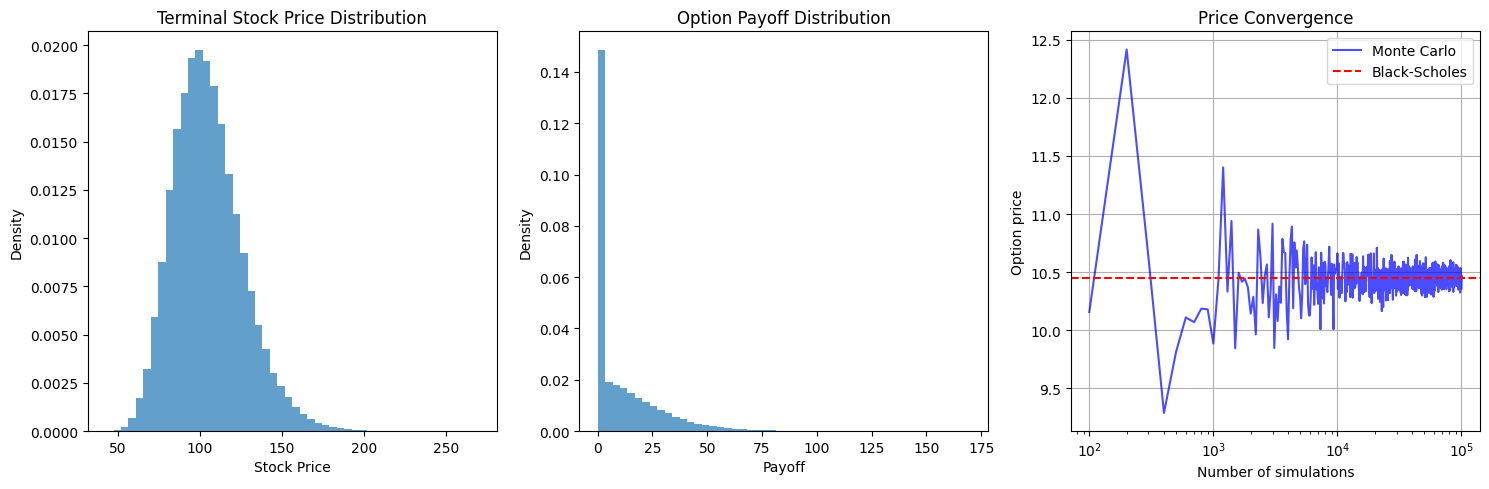

In [8]:
# Generate terminal stock prices and payoffs
n_simulations = 100000
S0, K, T, r, sigma = 100, 100, 1, 0.05, 0.2  # Parameters from interactive widgets
Z = np.random.standard_normal(n_simulations)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
payoffs = np.maximum(ST - K, 0)
mc_price = np.exp(-r * T) * np.mean(payoffs)
bs_price = black_scholes_call(S0, K, T, r, sigma)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Terminal price distribution
ax1.hist(ST, bins=50, density=True, alpha=0.7)
ax1.set_title('Terminal Stock Price Distribution')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Density')

# Plot 2: Payoff distribution
ax2.hist(payoffs, bins=50, density=True, alpha=0.7)
ax2.set_title('Option Payoff Distribution')
ax2.set_xlabel('Payoff')
ax2.set_ylabel('Density')

# Plot 3: Convergence analysis
n_steps = 10000  # Number of points to plot
step_size = 100  # Increment by 100 simulations each time
n_simulations_list = np.arange(100, 100000, step_size)
mc_prices = []

for n in n_simulations_list:
    Z = np.random.standard_normal(n)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    mc_prices.append(np.exp(-r * T) * np.mean(payoffs))

ax3.semilogx(n_simulations_list, mc_prices, 'b-', alpha=0.7, label='Monte Carlo')
ax3.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes')
ax3.set_xlabel('Number of simulations')
ax3.set_ylabel('Option price')
ax3.set_title('Price Convergence')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()